<a href="https://colab.research.google.com/github/baibai25/patoyata-gacha/blob/main/patoyata_gacha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import urllib
from PIL import Image
import matplotlib.pyplot as plt
import re

## gacha ratio simulation

In [2]:
np.random.seed()

In [3]:
rare = ['SSR', 'SR', 'R']
# proba = [0.03, 0.18, 0.79]
proba = [0.01, 0.09, 0.90]
sample_size = 10000

In [4]:
test_result = np.random.choice(a=rare, size=sample_size, p=proba)

In [5]:
cnt = Counter(test_result)
print(cnt)
print(np.array(list(cnt.values())))
print(100 * np.array(list(cnt.values())) / sample_size)

Counter({'R': 9016, 'SR': 877, 'SSR': 107})
[9016  877  107]
[90.16  8.77  1.07]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


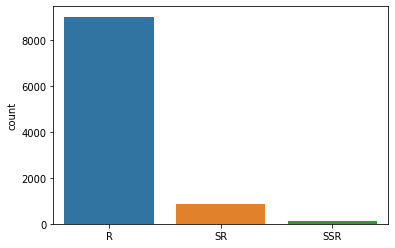

In [6]:
sns.countplot(test_result)

## dataset

In [7]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

In [8]:
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1nx47RQNXMtTrE3ntYsV9xtRsESGDmkO3pkWFbjKj3IM/edit#gid=0').sheet1

In [9]:
df = pd.DataFrame(worksheet.get_all_values())
df.columns = list(df.loc[0, :])
df.drop(0, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [10]:
tmp = []
for url in df['share_url']:
  if url == '':
    tmp.append('')
  else:
    id = re.search( r'(?<=d/).*(?=\/)', url)[0]
    tmp.append(f'https://drive.google.com/uc?export=view&id={id}')

df['url'] = tmp
df.drop('share_url', axis=1, inplace=True)
del tmp

In [11]:
# get all images
# 複数回実行すると403でるので注意
image_list = []
for index, url in enumerate(df['url']):
  img = Image.open(urllib.request.urlopen(url))
  image_list.append([index, img.resize((124, 124))])

## キャラ一覧

In [ ]:
# df[['rare', 'name']]
df

,rare,name,comment,url
0,SSR,Chris,,https://drive.google.com/uc?export=view&id=1Mg...
1,SSR,Donnis,,https://drive.google.com/uc?export=view&id=1ZS...
2,SSR,大谷遺伝子パト,,https://drive.google.com/uc?export=view&id=1T1...
3,SSR,Vカツ パト,,https://drive.google.com/uc?export=view&id=1mj...
4,SSR,Vカツ ヤタ,,https://drive.google.com/uc?export=view&id=1TH...
5,SSR,Mirrativ パト,,https://drive.google.com/uc?export=view&id=19X...
6,SSR,Mirrativ ヤタ,,https://drive.google.com/uc?export=view&id=1_l...
7,SSR,パトちゃん,,https://drive.google.com/uc?export=view&id=1sk...
8,SSR,ヤタちゃん,,https://drive.google.com/uc?export=view&id=1Fv...
9,SSR,スパプリ,None,https://drive.google.com/uc?export=view&id=1JV...


## gacha

In [12]:
def get_rare_result(rare, sample_size, proba):
  # np.random.seed()
  return np.random.choice(a=rare, size=sample_size, p=proba) # TODO: add pickup proba

In [13]:
def get_items(rare_result, df):
  count = Counter(rare_result)
  
  result = pd.DataFrame([], columns=df.columns)
  for rare, count in count.items():
    result = pd.concat([result, df[df['rare'] == rare].sample(n=count, replace=True).reset_index()], axis=0)
  return result

In [14]:
def set_params(size):
  rare = ['SSR', 'SR', 'R']
  # proba = [0.03, 0.18, 0.79]
  proba = [0.01, 0.09, 0.90]
  sample_size = size

  # check proba
  cnt = 0
  for val in proba:
    cnt += val
  assert val != 1.0

  return rare, proba, sample_size

In [15]:
def get_concat_h(im1, im2):
  dst = Image.new('RGB', (im1.width + im2.width, im1.height))
  dst.paste(im1, (0, 0))
  dst.paste(im2, (im1.width, 0))
  return dst

def get_concat_h_multi_blank(im_list):
  _im = im_list.pop(0)
  for im in im_list:
    _im = get_concat_h(_im, im)
  return _im

def display_images(result, image_list):
  img_list = [image_list[int(index)][1] for index in result['index']]
  display(get_concat_h_multi_blank(img_list))


In [25]:
def execute(size):
  rare, proba, sample_size =  set_params(size)
  rare_result = get_rare_result(rare, sample_size, proba)
  result = get_items(rare_result, df)
  display_images(result, image_list)
  return result

In [28]:
cnt = 0
np.random.seed()

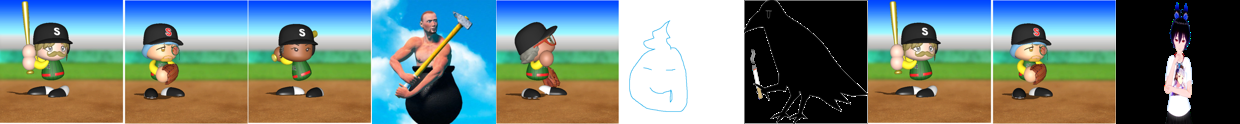

現在90連中


,rare,name
0,R,久我妹
1,R,久我弟
2,R,久我のカブトムシ
3,R,壺おじ
4,R,久我父
5,R,クソ精霊
6,R,カラス
7,R,久我妹
8,R,久我弟
0,SSR,Vカツ ヤタ


In [37]:
result = execute(10)
cnt += 1 * 10
print(f'現在{cnt}連中')
result[['rare', 'name']]